# 11.10 Adam算法
- **目录**
  - 11.10.1 Adam算法原理
  - 11.10.2 Adam算法实现
  - 11.10.3 Yogi
  - 11.10.4 AdamW算法

- 在本节讨论之前，先详细回顾一下这些技术：
  - 在11.4节中学习了：随机梯度下降在解决优化问题时比梯度下降更有效。
  - 在11.5节中学习了：在一个小批量中使用更大的观测值集，可以通过向量化提供额外效率。这是高效的多机、多GPU和整体并行处理的关键。
  - 在11.6节中动量法添加了一种机制，用于汇总过去梯度的历史以加速收敛。
  - 在11.7节中AdaGrad算法通过对每个坐标缩放来实现高效计算的预处理器。
  - 在11.8节中RMSProp通过学习率的调整来分离每个坐标的缩放。
- **Adam算法（Adaptive Moment Estimation，自适应矩估计）** 将所有**这些技术**汇总到一个高效的学习算法中。
- 不出预料，作为深度学习中使用的更强大和有效的优化算法之一，它非常受欢迎。
- 但是它并非没有问题，有时Adam算法可能**由于方差控制不良而发散**。
  - 在完善工作中，Adam算法提供了一个称为**Yogi**的**热补丁**来解决这些问题。

-------------
- **说明：**
- **（1）何为Adam算法可能由于方差控制不良而发散？**
  - Adam优化算法是一种广泛使用的优化方法，结合了Momentum和RMSProp的思想。然而，它也存在一些潜在问题，可能导致训练不稳定，特别是在某些非凸优化问题上。
  - **方差控制不良的问题**
    - 在某些情况下，由于梯度的不稳定，算法的二阶矩（即方差，指公式11.10.1中的 $\mathbf{g}_t^2$）可能变得非常大。
    - 当方差大的时候，学习率的调整可能不够灵敏，这可能导致学习率过大，从而使参数更新在最优解附近振荡。
  - **发散的具体表现**
    - **参数振荡**：在训练过程中，参数可能在一个值附近不断振荡，无法收敛到一个稳定的最优解。
    - **损失函数上升**：如果学习率过大，可能会导致损失函数不断上升，甚至发散。
  -  **举例说明:**
     - 假设我们有一个非常复杂的损失曲面，其中存在许多陡峭的山谷和尖锐的岭。
     - 在这样的情况下，如果我们使用Adam进行优化：
     - **初始阶段**：参数开始在损失曲面上移动，一切似乎正常。
     - **进入陡峭区域**：当参数进入一个陡峭的区域时，梯度可能突然变得非常大。此时，方差控制不良可能开始显现。
     - **振荡或发散**：由于学习率的调整不够灵敏，参数可能在山谷底部振荡，或者甚至跳出山谷，导致损失函数的值上升。
     - **训练失败**：如果不能适当地控制学习率，训练可能完全失败，无法找到一个好的解。
  - 为了克服这些问题，人们提出了许多Adam的变种，例如**AdamW**，以提供更稳定的训练。
-----------------

## 11.10.1 Adam算法原理

- Adam算法的关键组成部分之一是：它**使用指数加权移动平均值来估算梯度的动量和二次矩**，即它使用状态变量
$$\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned} \tag{11.10.1}$$
  - 这里$\beta_1$和$\beta_2$是非负加权参数。
  - 常将它们设置为$\beta_1 = 0.9$和$\beta_2 = 0.999$。
  - 也就是说，**方差估计的移动远远慢于动量估计的移动**。
- 注意，如果初始化$\mathbf{v}_0 = \mathbf{s}_0 = 0$，就会获得一个相当大的初始偏差。
- 可以通过使用$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$来解决这个问题。
- 相应地，标准化状态变量由下式获得
$$\hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \text{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}.\tag{11.10.2}$$
- 有了正确的估计，现在可以写出更新方程。
  - 首先，我们以非常类似于RMSProp算法的方式重新缩放梯度以获得
$$\mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}.\tag{11.10.3}$$
  - 与RMSProp不同，我们的**更新使用动量$\hat{\mathbf{v}}_t$而不是梯度本身**。
  - 此外，由于使用$\frac{1}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}$而不是$\frac{1}{\sqrt{\hat{\mathbf{s}}_t + \epsilon}}$进行缩放，两者会略有差异。
  - 前者在实践中效果略好一些，因此与RMSProp算法有所区分。
  - 通常，我们选择$\epsilon = 10^{-6}$，这是为了在数值稳定性和逼真度之间取得良好的平衡。
- 最后简单更新：
$$\mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'.\tag{11.10.4}$$
- 回顾Adam算法，它的设计灵感很清楚：
  - 首先，动量和规模在状态变量中清晰可见，
它们相当独特的定义使我们移除偏项（这可以通过稍微不同的初始化和更新条件来修正）。
  - 其次，RMSProp算法中两项的组合都非常简单。
  - 最后，明确的学习率$\eta$使我们能够控制步长来解决收敛问题。

-----
- **说明：**
- **（1）为何说“方差估计的移动远远慢于动量估计的移动。”？**
  - 在Adam算法中，“方差估计的移动远远慢于动量估计的移动”是指使用两个不同的超参数来控制梯度的一阶和二阶矩的移动平均。
  - **一阶矩的移动平均（动量估计）**
    -  $\beta_1$通常设置为 0.9，表示当前梯度占10%的权重，而过去的动量估计占90%的权重。
  - **二阶矩的移动平均（方差估计）**
    $\beta_2$ 通常设置为 0.999，表示当前梯度的平方只占0.1%的权重，而过去的方差估计占99.9%的权重。
  -  **比较一阶和二阶矩的移动速度**
  - **动量估计的移动速度较快**：
    - 由于 $\beta_1$ 通常设置为 0.9，一阶矩的估计能够更快地反映梯度的变化。
    - 换句话说，最近的梯度在动量估计中占更大的权重。
  - **方差估计的移动速度较慢**：
    - 由于$\beta_2$ 通常设置为 0.999，二阶矩的估计对最近的梯度变化反应较慢。
    - 最近的梯度在方差估计中的权重非常小。
  - **举例**:
    - 假设我们有一个梯度序列，其中梯度在某个时刻突然增大。
    - 由于$\beta_1 < \beta_2$，一阶矩（动量）的估计会更快地反映这种变化，而二阶矩（方差）的估计会更慢地适应新的梯度规模。
    - 因此，方差估计的移动远远慢于动量估计的移动。
  - **结论**
    - 一阶矩和二阶矩的不同移动速度有助于平衡算法的灵敏度和稳定性。
    - 动量估计的快速移动有助于算法更迅速地适应梯度的变化，而方差估计的慢速移动有助于防止由于短期波动造成的过度调整。
    - 这种设计是Adam算法成功的关键因素之一。

- **（2）为何说“如果初始化 𝐯0=𝐬0=0 ，就会获得一个相当大的初始偏差”？**
  - 在Adam算法中，梯度的一阶和二阶矩通过指数加权移动平均来估计。
  - 状态变量$\mathbf{v}_t$和$\mathbf{s}_t$分别估计梯度的一阶和二阶矩。
  -  **一阶和二阶矩的初始化**
     - 如果我们将$\mathbf{v}_0$和$\mathbf{s}_0$初始化为0，当首次观察到梯度时，这些状态变量将从零开始累积信息。
     - 当$\beta_1$和$\beta_2$的值接近于1时，之前的估计会在新的估计中占有较大的权重。
  -  **初始估计偏低**
     - 由于在初始步骤中历史梯度全为零，所以一阶和二阶矩的估计会偏低。
     - 因此这种估计和真实梯度相差很远，因此称之为 **“相当大的初始偏差”**。
     - 这会使得算法对初始梯度反应迟缓。
  -  **偏差修正**
     - 为了解决这个问题，Adam算法引入了偏差修正。
     - 通过将状态变量$\mathbf{v}_t$和$\mathbf{s}_t$分别除以$1 - \beta_1^t$和$1 - \beta_2^t$，可以减轻初始估计的偏低问题，见公式$11.10.2$
     - 这样，即使初始估计偏低，算法也能更快地适应真实的梯度规模。
  - 因此通过零初始化状态变量$\mathbf{v}_0$和$\mathbf{s}_0$，Adam算法的初始估计可能会偏低，但通过引入偏差修正机制，算法能够快速适应梯度的真实规模，并避免初始步骤中的大偏差。这也是Adam算法效果良好的关键因素之一。

- **（3）几何级数公式$\sum_{i=0}^t \beta^i = \frac{1 - \beta^t}{1 - \beta}$的用途**
  - 上述的几何级数和在解释Adam算法的初始化偏差时有概念上的用途。
  - 对于特定的$\beta$值，几何级数$\sum_{i=0}^t \beta^i$可以描述如何平滑过去的梯度值，因此有助于理解算法的动态过程。
  - 然而，在具体的Adam算法的公式中，你不会看到直接使用这个几何级数的和。
  - 这个和的表达式$\frac{1 - \beta^t}{1 - \beta}$提供了一种**理解$\beta$如何权衡不同历史梯度**的方式，但并不直接参与计算。
  - 公式$11.10.2$中使用的$\beta_1^t$和$\beta_2^t$是为了消除由于初始估计值$\mathbf{v}_0$和$\mathbf{s}_0$为0造成的偏差，这个操作与几何级数的和没有直接关系。
  - 总的来说，几何级数的和有助于理解算法的性质和动态，但并不直接用于算法的计算中。

- **（4）梯度的一阶矩和二阶矩有何用途？**
  - 在概率和统计中，矩是用于描述分布形状的量度，一阶矩和二阶矩分别对应于分布的均值和方差。
  - **一阶矩（First Moment）**: 这是数学期望或均值，用来描述分布的"中心"。在上下文中，梯度的一阶矩即$\mathbf{g}_t$，表示了梯度的平均或期望方向，与分布的均值或一阶矩有直接关系。
  - **二阶矩（Second Moment）**: 这是方差，描述了分布的"宽度"或"散布"。在上下文中，梯度的二阶矩即$\mathbf{g}_t^2$，表示了梯度的平方或方差，与分布的二阶矩有直接关系。(个人感觉和数理统计里矩的严格定义有出入)
  - 在Adam算法中，一阶矩和二阶矩的估计分别用于计算动量和规模，有助于更精确地调整梯度下降的方向和步长。动量部分通过估计梯度的平均方向来增加更新的方向性一致性，而规模部分通过考虑梯度的变化量来自适应地调整学习率。
  - 因此，通过使用一阶和二阶矩的估计，Adam算法试图结合梯度的均值和方差信息来提供更稳定和有效的优化。

-----------

## 11.10.2 Adam算法实现

- 从头开始实现Adam算法并不难。
为方便起见，我们将时间步$t$存储在`hyperparams`字典中。
除此之外，一切都很简单。

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

- Adam算法代码与公式对照说明：
  
<img src='../img/11_10_1.png'>

- 现在用以上Adam算法来训练模型，这里使用$\eta = 0.01$的学习率。


loss: 0.244, 0.040 sec/epoch


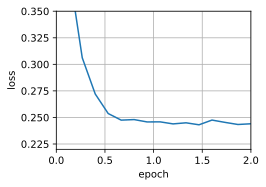

In [2]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

- 此外可以用深度学习框架自带算法应用Adam算法，只需要传递配置参数。


loss: 0.243, 0.034 sec/epoch


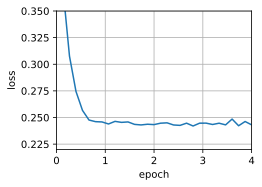

In [3]:
trainer = torch.optim.Adam
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 11.10.3 Yogi
- Adam算法也存在一些问题：
  - 即使在凸环境下，当$\mathbf{s}_t$的二次矩估计值爆炸时，它可能无法收敛。
- 有学者为$\mathbf{s}_t$提出了的改进更新和参数初始化。
- 建议重写Adam算法更新如下：
$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right).\tag{11.10.5}$$
  - 每当$\mathbf{g}_t^2$具有值很大的变量或更新很稀疏时，$\mathbf{s}_t$可能会太快地“忘记”过去的值。
  - 一个有效的解决方法是将$\mathbf{g}_t^2 - \mathbf{s}_{t-1}$替换为$\mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1})$。
- 这就是Yogi更新，现在更新的规模不再取决于偏差的量。
$$\mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\mathrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}).\tag{11.10.6}$$
- 建议用**更大的初始批量来初始化动量**，而不仅仅是初始的逐点估计。


loss: 0.243, 0.031 sec/epoch


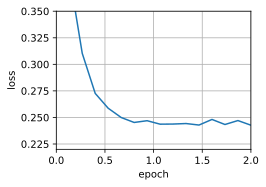

In [4]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            ## 公式11.10.6，Yogi更新
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## 11.10.4 AdamW算法
- AdamW 是 Adam 优化算法的一个改进版本，由 Ilya Loshchilov 和 Frank Hutter 在论文 [**Decoupled Weight Decay Regularization**](https://arxiv.org/abs/1711.05101) 中提出。

- **AdamW**适用于训练大规模，其特点稳定、泛化能力强，特别适用于计算开销大的大语言模型，包括GPT-3, ChatGPT-4o, BERT等模型都是用该优化算法。

- AdamW 的核心思想是**解耦权重衰减（Weight Decay）和学习率更新**，从而更好地实现正则化，避免 Adam 中权重衰减与自适应学习率之间的冲突。

- 在原始的 Adam 优化器中，权重衰减（Weight Decay）被直接添加到梯度更新中，导致权重衰减与自适应学习率之间存在耦合。这种耦合会导致以下问题：
  - **权重衰减效果不稳定**：由于 Adam 的自适应学习率机制，权重衰减的效果会受到学习率的影响，导致正则化效果不一致。
  - **过拟合风险增加**：在某些情况下，Adam 的权重衰减可能无法有效防止过拟合。

- AdamW 通过将权重衰减从梯度更新中解耦出来，解决了上述问题。
- 具体改进如下：
  - 状态变量$\hat{\mathbf{s}}_t$和$\hat{\mathbf{v}}_t$的计算方式与公式11.10.1,11.10.2一致。
  - 在 AdamW 中，权重衰减被单独处理，不参与梯度计算：
    $$
      x_{t} = x_{t-1} - \eta \left( \frac{\hat{\mathbf{s}}_t}{\sqrt{\hat{\mathbf{v}}_t} + \epsilon} + \lambda x_{t-1} \right) \tag{11.10.8}
    $$




loss: 0.243, 0.031 sec/epoch


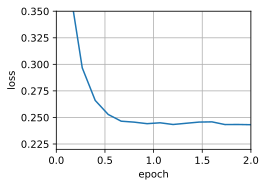

In [5]:
# AdamW参数初始化
def init_adamw_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))
    
# AdamW算法实现
def adamw(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            # 公式11.10.8
            p[:] -=  hyperparams['lr'] * (v_bias_corr / (torch.sqrt(s_bias_corr) + eps) +       
                                               hyperparams['lambda']*p[:])
        p.grad.data.zero_()
    hyperparams['t'] += 1
# 训练自定义模型
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adamw, init_adamw_states(feature_dim),
               {'lr': 0.01,'lambda' : 0.02, 't': 1}, data_iter, feature_dim);

loss: 0.245, 0.035 sec/epoch


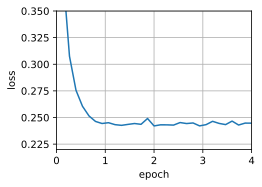

In [6]:
# AdamW简洁实现
trainer = torch.optim.AdamW
d2l.train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 小结

* Adam算法将许多优化算法的功能结合到了相当强大的更新规则中。
* Adam算法在RMSProp算法基础上创建的，还在小批量的随机梯度上使用EWMA。
* 在估计动量和二次矩时，Adam算法使用偏差校正来调整缓慢的启动速度。
* 对于具有显著差异的梯度，我们可能会遇到收敛性问题。我们可以通过使用更大的小批量或者切换到改进的估计值$\mathbf{s}_t$来修正它们。Yogi提供了这样的替代方案。